In [1]:
# import Libraries
import numpy as np
from matplotlib import pyplot
import tensorflow as tf
import seaborn as sns
from pandas import read_csv, DataFrame, concat
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM, Bidirectional
from sklearn.metrics import r2_score
from data import *
from tensorflow.keras.regularizers import l2
import os.path
from tensorflow.keras.models import load_model
from sklearn.metrics import mean_absolute_error

In [8]:
def LSTM_model(city, n_past):
    # load dataset
    dataset = read_csv('./data/' + city + '.csv', header=0, index_col=0)

    # AT_avg, CO_avg, NH3_avg, NO_avg, NO2_avg, NOx_avg, Ozone_avg, PM2.5_avg, PM10_avg, RH_avg, SO2_avg, SR_avg, Temp_avg, WS_avg, Confirmed
    dataset.drop(['Date', 'Recovered', 'Deceased', 'AT_avg', 'NH3_avg', 'NO_avg', 'NO2_avg', 'NOx_avg', 'Ozone_avg', 'PM2.5_avg', 'PM10_avg', 'SO2_avg', 'SR_avg', 'Temp_avg', 'WS_avg'], axis=1, inplace=True)
        
    values = dataset.values

    # ensure all data is float
    values = values.astype('float32')

    # normalize features
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_values = scaler.fit_transform(values)

    train = scaled_values[:250, :]
    test = scaled_values[250:, :]

    trainX = []
    trainY = []
    testX = []
    testY = []
    n_future = 1

    for i in range(n_past, len(train) - n_future + 1):
        trainX.append(train[i - n_past:i, 0:scaled_values.shape[1]])
        trainY.append(train[i + n_future - 1:i + n_future, -1])

    for i in range(n_past, len(test) - n_future + 1):
        testX.append(test[i - n_past:i, 0:scaled_values.shape[1]])
        testY.append(test[i + n_future - 1:i + n_future, -1])

    trainX, trainY = np.array(trainX), np.array(trainY)
    testX, testY = np.array(testX), np.array(testY)

    # LSTM model
    lstm_model = Sequential()
    lstm_model.add(LSTM(100, input_shape=(trainX.shape[1], trainX.shape[2]), kernel_regularizer=tf.keras.regularizers.l1_l2(0.01, 0.01),
                                  bias_regularizer=tf.keras.regularizers.l1_l2(0.01, 0.01), activity_regularizer=tf.keras.regularizers.l1_l2(0.01, 0.01)))
    lstm_model.add(Dense(512, bias_regularizer=tf.keras.regularizers.l1_l2(0.01, 0.00), activity_regularizer=tf.keras.regularizers.l1_l2(0.01, 0.00)))
    lstm_model.add(Dense(trainY.shape[1]))
    lstm_model.compile(loss='mae', optimizer='adam', metrics=['mean_absolute_error'])

    # fit network
    lstm_model.fit(trainX, trainY, epochs=100, batch_size=1, verbose=1)
    lstm_model.summary()

    # evaluate model
    lstm_model.evaluate(testX, testY)

    # make a prediction
    lstm_yhat_pred = lstm_model.predict(testX)
    forecast_copies = np.repeat(lstm_yhat_pred, scaled_values.shape[1], axis=-1)
    lstm_yhat = scaler.inverse_transform(forecast_copies)[:, -1]

    lstm_training_values_pred = lstm_model.predict(trainX)
    forecast_copies = np.repeat(lstm_training_values_pred, scaled_values.shape[1], axis=-1)
    lstm_training_values = scaler.inverse_transform(forecast_copies)[:, -1]

    forecast_copies = np.repeat(trainY, scaled_values.shape[1], axis=-1)
    trainY_check = scaler.inverse_transform(forecast_copies)[:, -1]

    forecast_copies = np.repeat(testY, scaled_values.shape[1], axis=-1)
    testY_check = scaler.inverse_transform(forecast_copies)[:, -1]

    lstm_trainScore = r2_score(trainY_check, lstm_training_values)
    lstm_testScore = r2_score(testY_check, lstm_yhat)
    print("Train Score: ", lstm_trainScore.round(3))
    print("Test Score: ", lstm_testScore.round(3))

    # reshape
    lstm_yhat = lstm_yhat.reshape([testX.shape[0]])
    lstm_training_values = lstm_training_values.reshape([trainX.shape[0]])

    # predicted plot
    predicted_plot_1 = np.append(trainY_check, testY_check)

    # training plot
    training_plot_1 = np.zeros(len(dataset))
    training_plot_1[:] = np.nan
    training_plot_1[:trainX.shape[0]] = lstm_training_values

    # testing plot
    testing_plot_1 = np.zeros(len(dataset)-1)
    testing_plot_1[:] = np.nan
    testing_plot_1[trainX.shape[0]:trainX.shape[0] + testX.shape[0]] = lstm_yhat

    # plot using matplotlib
    pyplot.figure(figsize=(15, 10))
    pyplot.plot(predicted_plot_1, label='actual plot')
    pyplot.plot(training_plot_1, label='estimated training plot')
    pyplot.plot(testing_plot_1, label='estimated testing plot')
    pyplot.title(city)
    pyplot.legend()
    pyplot.savefig('./pic/' + city + 'LSTM.png', dpi=1200, bbox_inches='tight')
    pyplot.show()

    # MAE
    print("30 predictions", mean_absolute_error(testY_check[:30], lstm_yhat[:30]))
    print("100 predicitions", mean_absolute_error(testY_check[:100], lstm_yhat[:100]))
    print("Total MAE", mean_absolute_error(testY_check, lstm_yhat))
    lstm_model.save("models/" + city + " LSTM model" + ".h5")


In [5]:
def BiLSTM_model(city, n_past):
    # load dataset
    dataset = read_csv('./data/' + city + '.csv', header=0, index_col=0)

    # AT_avg, CO_avg, NH3_avg, NO_avg, NO2_avg, NOx_avg, Ozone_avg, PM2.5_avg, PM10_avg, RH_avg, SO2_avg, SR_avg, Temp_avg, WS_avg, Confirmed
    dataset.drop(['Date', 'Recovered', 'Deceased', 'AT_avg', 'CO_avg', 'NH3_avg', 'NO_avg', 'NO2_avg', 'NOx_avg', 'Ozone_avg', 'PM2.5_avg', 'PM10_avg', 'RH_avg', 'SO2_avg', 'SR_avg', 'Temp_avg', 'WS_avg'], axis=1, inplace=True)
    values = dataset.values

    # ensure all data is float
    values = values.astype('float32')

    # normalize features
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_values = scaler.fit_transform(values)

    train = scaled_values[:250, :]
    test = scaled_values[250:, :]

    trainX = []
    trainY = []
    testX = []
    testY = []
    n_future = 1

    for i in range(n_past, len(train) - n_future + 1):
        trainX.append(train[i - n_past:i, 0:scaled_values.shape[1]])
        trainY.append(train[i + n_future - 1:i + n_future, -1])

    for i in range(n_past, len(test) - n_future + 1):
        testX.append(test[i - n_past:i, 0:scaled_values.shape[1]])
        testY.append(test[i + n_future - 1:i + n_future, -1])

    trainX, trainY = np.array(trainX), np.array(trainY)
    testX, testY = np.array(testX), np.array(testY)

    # BiLSTM model
    bilstm_model = Sequential()
    bilstm_model.add(Bidirectional(LSTM(100, kernel_regularizer=tf.keras.regularizers.l1_l2(0.01, 0.01),
                                  bias_regularizer=tf.keras.regularizers.l1_l2(0.01, 0.01), activity_regularizer=tf.keras.regularizers.l1_l2(0.01, 0.01))))
    bilstm_model.add(Dense(512, bias_regularizer=tf.keras.regularizers.l1_l2(0.01, 0.00), activity_regularizer=tf.keras.regularizers.l1_l2(0.01, 0.00)))
    bilstm_model.add(Dense(1))
    bilstm_model.compile(loss='mae', optimizer='adam', metrics=['mean_absolute_error'])

    # fit network
    bilstm_model.fit(trainX, trainY, epochs=100, batch_size=1, verbose=1)
    bilstm_model.summary()

    # evaluate model
    bilstm_model.evaluate(testX, testY)

    # make a prediction
    bilstm_yhat_pred = bilstm_model.predict(testX)
    forecast_copies = np.repeat(bilstm_yhat_pred, scaled_values.shape[1], axis=-1)
    bilstm_yhat = scaler.inverse_transform(forecast_copies)[:, -1]

    bilstm_training_values_pred = bilstm_model.predict(trainX)
    forecast_copies = np.repeat(bilstm_training_values_pred, scaled_values.shape[1], axis=-1)
    bilstm_training_values = scaler.inverse_transform(forecast_copies)[:, -1]

    forecast_copies = np.repeat(trainY, scaled_values.shape[1], axis=-1)
    trainY_check = scaler.inverse_transform(forecast_copies)[:, -1]

    forecast_copies = np.repeat(testY, scaled_values.shape[1], axis=-1)
    testY_check = scaler.inverse_transform(forecast_copies)[:, -1]

    bilstm_trainScore = r2_score(trainY_check, bilstm_training_values)
    bilstm_testScore = r2_score(testY_check, bilstm_yhat)
    print("Train Score: ", bilstm_trainScore.round(3))
    print("Test Score: ", bilstm_testScore.round(3))

    # reshape
    bilstm_yhat = bilstm_yhat.reshape([testX.shape[0]])
    bilstm_training_values = bilstm_training_values.reshape([trainX.shape[0]])

    # predicted plot
    predicted_plot = np.append(trainY_check, testY_check)

    # training plot
    training_plot = np.zeros(len(dataset))
    training_plot[:] = np.nan
    training_plot[:trainX.shape[0]] = bilstm_training_values

    # testing plot
    testing_plot = np.zeros(len(dataset)-1)
    testing_plot[:] = np.nan
    testing_plot[trainX.shape[0]:trainX.shape[0] + testX.shape[0]] = bilstm_yhat

    # plot using matplotlib
    pyplot.figure(figsize=(15, 10))
    pyplot.plot(predicted_plot, label='actual plot')
    pyplot.plot(training_plot, label='estimated training plot')
    pyplot.plot(testing_plot, label='estimated testing plot')
    pyplot.title(city)
    pyplot.legend()
    pyplot.savefig('./pic/' + city + 'BiLSTM.png', dpi=1200, bbox_inches='tight')
    pyplot.show()

    # MAE
    print("30 predictions", mean_absolute_error(testY_check[:30], bilstm_yhat[:30]))
    print("100 predicitions", mean_absolute_error(testY_check[:100], bilstm_yhat[:100]))
    print("Total MAE", mean_absolute_error(testY_check, bilstm_yhat))
    bilstm_model.save("models/" + city + " BiLSTM model.h5")

Train on 243 samples
Epoch 1/100
243/243 [==============================] - 3s 11ms/sample - loss: 1.9504 - mean_absolute_error: 0.0311
Epoch 2/100
243/243 [==============================] - 1s 4ms/sample - loss: 1.1820 - mean_absolute_error: 0.0203
Epoch 3/100
243/243 [==============================] - 1s 4ms/sample - loss: 0.7315 - mean_absolute_error: 0.0191
Epoch 4/100
243/243 [==============================] - 1s 4ms/sample - loss: 0.4064 - mean_absolute_error: 0.0193
Epoch 5/100
243/243 [==============================] - 1s 4ms/sample - loss: 0.1735 - mean_absolute_error: 0.0168
Epoch 6/100
243/243 [==============================] - 1s 4ms/sample - loss: 0.0524 - mean_absolute_error: 0.0181
Epoch 7/100
243/243 [==============================] - 1s 5ms/sample - loss: 0.0434 - mean_absolute_error: 0.0176
Epoch 8/100
243/243 [==============================] - 1s 5ms/sample - loss: 0.0382 - mean_absolute_error: 0.0147
Epoch 9/100
243/243 [==============================] - 1s 5ms/samp

Train Score:  0.994
Test Score:  0.982


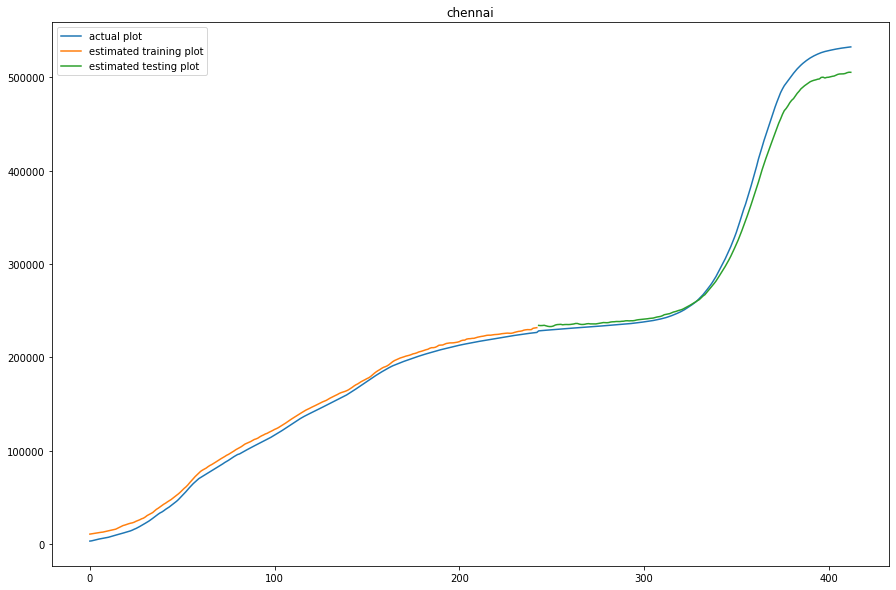

30 predictions 4248.3774
100 predicitions 3264.8787
Total MAE 11636.577


In [10]:
LSTM_model('chennai', 2, 7)

Train on 243 samples
Epoch 1/100
243/243 [==============================] - 3s 11ms/sample - loss: 1.9570 - mean_absolute_error: 0.0436
Epoch 2/100
243/243 [==============================] - 1s 5ms/sample - loss: 1.1746 - mean_absolute_error: 0.0202
Epoch 3/100
243/243 [==============================] - 1s 5ms/sample - loss: 0.7275 - mean_absolute_error: 0.0232
Epoch 4/100
243/243 [==============================] - 1s 5ms/sample - loss: 0.4000 - mean_absolute_error: 0.0198
Epoch 5/100
243/243 [==============================] - 1s 5ms/sample - loss: 0.1703 - mean_absolute_error: 0.0185
Epoch 6/100
243/243 [==============================] - 1s 5ms/sample - loss: 0.0478 - mean_absolute_error: 0.0172
Epoch 7/100
243/243 [==============================] - 1s 5ms/sample - loss: 0.0343 - mean_absolute_error: 0.0122
Epoch 8/100
243/243 [==============================] - 1s 5ms/sample - loss: 0.0314 - mean_absolute_error: 0.0109
Epoch 9/100
243/243 [==============================] - 1s 5ms/samp

Train Score:  0.968
Test Score:  0.976


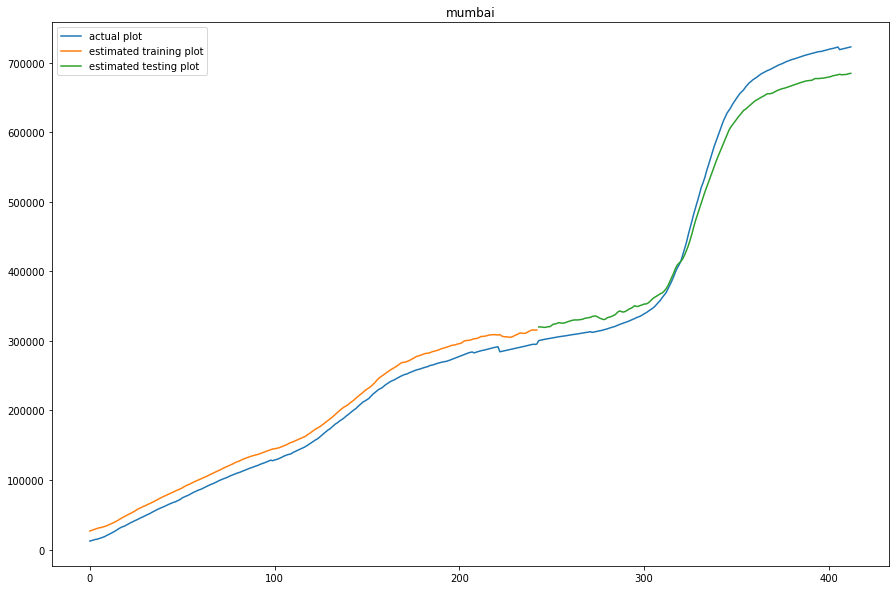

30 predictions 19525.45
100 predicitions 16957.695
Total MAE 24594.69


In [11]:
LSTM_model('mumbai', 2, 7)